In [151]:

import os
import math
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from scipy.sparse import csr_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import csr_matrix
from collections import defaultdict
import heapq

from surprise import Dataset, Reader, SVD
from surprise.model_selection import train_test_split
from surprise import accuracy
from surprise import dump
from functools import lru_cache
from scipy.sparse import save_npz, load_npz
import joblib

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Загружаем данные
ratings = pd.read_csv('ratings.csv')
books = pd.read_csv('books.csv')
tags = pd.read_csv('tags.csv')
book_tags = pd.read_csv('book_tags.csv')

# Быстрый обзор
print(ratings.head())
print(books.info())
print(tags.info())
print(book_tags.info())

   book_id  user_id  rating
0        1      314       5
1        1      439       3
2        1      588       5
3        1     1169       4
4        1     1185       4
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 23 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id                         10000 non-null  int64  
 1   book_id                    10000 non-null  int64  
 2   best_book_id               10000 non-null  int64  
 3   work_id                    10000 non-null  int64  
 4   books_count                10000 non-null  int64  
 5   isbn                       9300 non-null   object 
 6   isbn13                     9415 non-null   float64
 7   authors                    10000 non-null  object 
 8   original_publication_year  9979 non-null   float64
 9   original_title             9415 non-null   object 
 10  title                      10000 non-null  obje

In [11]:
books.head()

,id,book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,...,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url
0,1,2767052,2767052,2792775,272,439023483,9.780439e+12,Suzanne Collins,2008.0,The Hunger Games,...,4780653,4942365,155254,66715,127936,560092,1481305,2706317,https://images.gr-assets.com/books/1447303603m...,https://images.gr-assets.com/books/1447303603s...
1,2,3,3,4640799,491,439554934,9.780440e+12,"J.K. Rowling, Mary GrandPré",1997.0,Harry Potter and the Philosopher's Stone,...,4602479,4800065,75867,75504,101676,455024,1156318,3011543,https://images.gr-assets.com/books/1474154022m...,https://images.gr-assets.com/books/1474154022s...
2,3,41865,41865,3212258,226,316015849,9.780316e+12,Stephenie Meyer,2005.0,Twilight,...,3866839,3916824,95009,456191,436802,793319,875073,1355439,https://images.gr-assets.com/books/1361039443m...,https://images.gr-assets.com/books/1361039443s...
3,4,2657,2657,3275794,487,61120081,9.780061e+12,Harper Lee,1960.0,To Kill a Mockingbird,...,3198671,3340896,72586,60427,117415,446835,1001952,1714267,https://images.gr-assets.com/books/1361975680m...,https://images.gr-assets.com/books/1361975680s...
4,5,4671,4671,245494,1356,743273567,9.780743e+12,F. Scott Fitzgerald,1925.0,The Great Gatsby,...,2683664,2773745,51992,86236,197621,606158,936012,947718,https://images.gr-assets.com/books/1490528560m...,https://images.gr-assets.com/books/1490528560s...


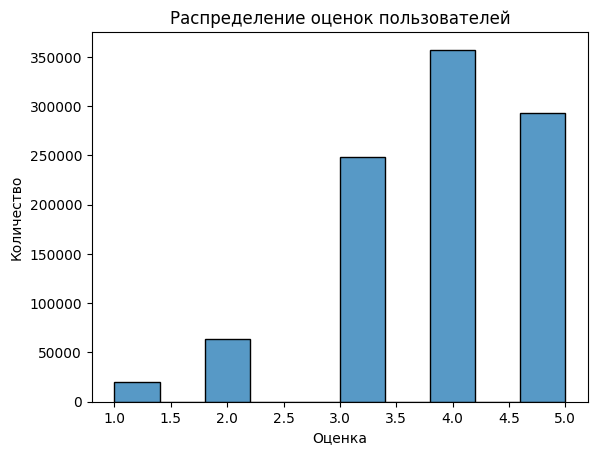

In [12]:
#Распределение оценок. Есть ли смещение в сторону высоких оценок?
sns.histplot(ratings['rating'], bins=10, kde=False)
plt.title("Распределение оценок пользователей")
plt.xlabel("Оценка")
plt.ylabel("Количество")
plt.show()


Смещении в сторону высоких оценок:

Пользователи чаще ставят хорошие оценки тем книгам, которые изначально им нравятся.

Модель может переоценивать популярные книги и недооценивать менее известные.

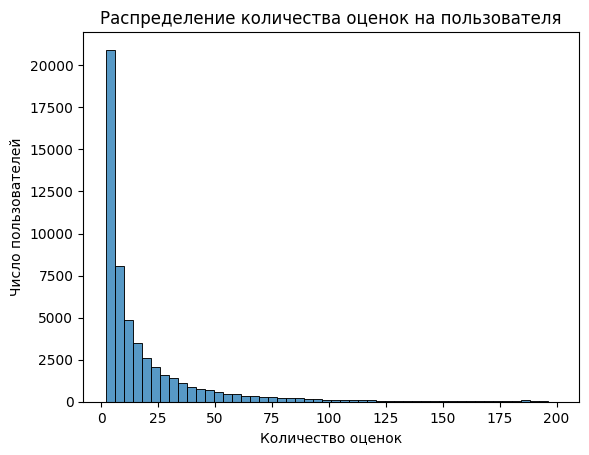

count    53424.000000
mean        18.376685
std         26.268690
min          2.000000
25%          3.000000
50%          8.000000
75%         22.000000
max        200.000000
Name: book_id, dtype: float64


In [13]:
#понять, сколько оценок ставит один пользователь. Это поможет заметить проблему холодного старта.
user_activity = ratings.groupby('user_id')['book_id'].count()

sns.histplot(user_activity, bins=50)
plt.title("Распределение количества оценок на пользователя")
plt.xlabel("Количество оценок")
plt.ylabel("Число пользователей")
plt.show()

print(user_activity.describe())


Данные разреженные — много пользователей с минимальной историей.

Проблема холодного старта: у новых или пассивных пользователей модель не сможет делать точные прогнозы.

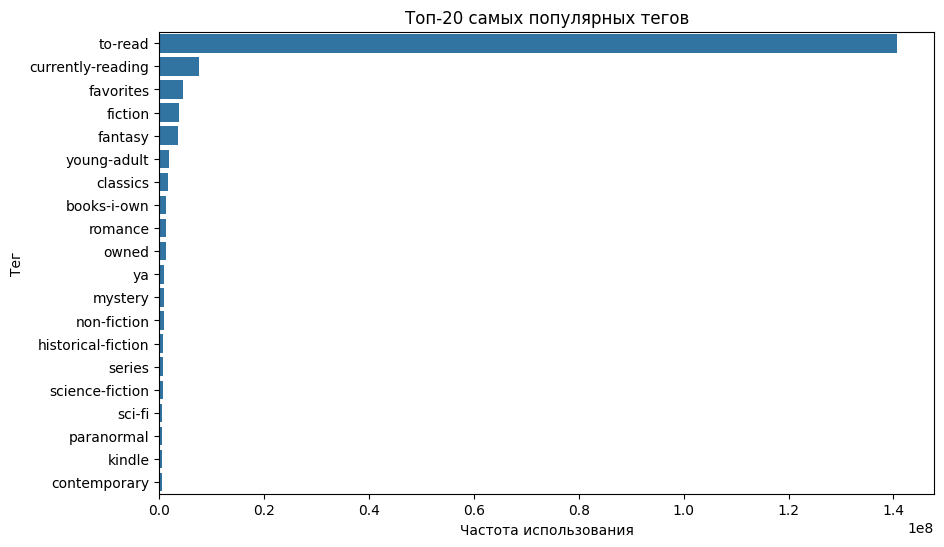

In [14]:
#Анализ тегов какие темы встречаются чаще всего.
# Объединяем book_tags и tags
book_tags_full = book_tags.merge(tags, on='tag_id', how='left')

top_tags = (
    book_tags_full.groupby('tag_name')['count']
    .sum()
    .sort_values(ascending=False)
    .head(20)
)

plt.figure(figsize=(10,6))
sns.barplot(y=top_tags.index, x=top_tags.values)
plt.title("Топ-20 самых популярных тегов")
plt.xlabel("Частота использования")
plt.ylabel("Тег")
plt.show()

Смещение популярности — небольшой набор тегов получает основную долю внимания.

множество редко встречающихся тегов с очень малым числом взаимодействий.

In [15]:
#Неперсонализированная модель (Baseline)
#книги с наибольшим средним рейтингом, если у них достаточно оценок (чтобы отсеять случайные всплески)

# Считаем средний рейтинг и количество оценок по каждой книге 
book_stats = ratings.groupby('book_id').agg(
    avg_rating=('rating', 'mean'),
    num_ratings=('rating', 'count')
).reset_index()

# === 3. Фильтруем: книги, у которых хотя бы 50 оценок ===
popular_books = book_stats[book_stats['num_ratings'] >= 50]

# === 4. Сортируем по среднему рейтингу (в порядке убывания) ===
top_books = popular_books.sort_values(['avg_rating','num_ratings'], ascending=[False, False])

# === 5. Присоединяем названия книг из books.csv ===
top_books = top_books.merge(
    books[['book_id', 'original_title']],
    on='book_id',
    how='left'
)

# === 6. Выводим итоговый список самых популярных книг ===
print(top_books[['original_title', 'avg_rating', 'num_ratings']])


                  original_title  avg_rating  num_ratings
0                            NaN    4.820225           89
1                            NaN    4.780000          100
2                            NaN    4.780000          100
3     Still Life with Woodpecker    4.777778           99
4                            NaN    4.774194           93
...                          ...         ...          ...
9985                         NaN    2.430000          100
9986                         NaN    2.350515           97
9987                         NaN    2.312500           64
9988                         NaN    2.235294           85
9989                         NaN    1.960000          100

[9990 rows x 3 columns]


In [16]:
books['original_title'].isna().sum()


585

In [17]:
books['original_title'].count()

9415

In [57]:

# Группируем теги по книге, объединяя их в одну строку
book_tag_texts = book_tags_full.groupby('goodreads_book_id')['tag_name'].apply(lambda x: ' '.join(x)).reset_index()

In [19]:
# Заполним пропуски в оригинальных названиях
books['original_title'] = books['original_title'].fillna(books['title'])

In [20]:
books['original_title'].isna().sum()

0

In [21]:
# Соединяем книги и их теги
books_with_tags = books.merge(book_tag_texts, left_on='book_id', right_on='goodreads_book_id', how='left')


In [22]:
#  Создаём текстовый профиль книги 
books_with_tags['text_profile'] = books_with_tags['original_title'].fillna('') + ' ' + books_with_tags['tag_name'].fillna('')

In [153]:
books_with_tags_set = set(books_with_tags['book_id'].unique()) if 'books_with_tags' in globals() else set()

In [155]:
books_with_tags['text_profile'].head(1)

0    The Hunger Games favorites currently-reading y...
Name: text_profile, dtype: object

In [24]:
# Векторизация TF-IDF 
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(books_with_tags['text_profile'])

In [150]:
joblib.dump(tfidf, 'tfidf_vectorizer.joblib')
joblib.dump(tfidf_matrix, 'tfidf_matrix.joblib')  # если большая, можно использовать scipy.sparse save_npz

save_npz('tfidf_matrix.npz', tfidf_matrix)

In [25]:
books_with_tags.head()

,id,book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,...,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url,goodreads_book_id,tag_name,text_profile
0,1,2767052,2767052,2792775,272,439023483,9.780439e+12,Suzanne Collins,2008.0,The Hunger Games,...,66715,127936,560092,1481305,2706317,https://images.gr-assets.com/books/1447303603m...,https://images.gr-assets.com/books/1447303603s...,2767052,favorites currently-reading young-adult fictio...,The Hunger Games favorites currently-reading y...
1,2,3,3,4640799,491,439554934,9.780440e+12,"J.K. Rowling, Mary GrandPré",1997.0,Harry Potter and the Philosopher's Stone,...,75504,101676,455024,1156318,3011543,https://images.gr-assets.com/books/1474154022m...,https://images.gr-assets.com/books/1474154022s...,3,to-read favorites fantasy currently-reading yo...,Harry Potter and the Philosopher's Stone to-re...
2,3,41865,41865,3212258,226,316015849,9.780316e+12,Stephenie Meyer,2005.0,Twilight,...,456191,436802,793319,875073,1355439,https://images.gr-assets.com/books/1361039443m...,https://images.gr-assets.com/books/1361039443s...,41865,young-adult fantasy favorites vampires ya fict...,Twilight young-adult fantasy favorites vampire...
3,4,2657,2657,3275794,487,61120081,9.780061e+12,Harper Lee,1960.0,To Kill a Mockingbird,...,60427,117415,446835,1001952,1714267,https://images.gr-assets.com/books/1361975680m...,https://images.gr-assets.com/books/1361975680s...,2657,classics favorites to-read classic historical-...,To Kill a Mockingbird classics favorites to-re...
4,5,4671,4671,245494,1356,743273567,9.780743e+12,F. Scott Fitzgerald,1925.0,The Great Gatsby,...,86236,197621,606158,936012,947718,https://images.gr-assets.com/books/1490528560m...,https://images.gr-assets.com/books/1490528560s...,4671,classics favorites fiction classic books-i-own...,The Great Gatsby classics favorites fiction cl...


In [27]:
# Функция поиска похожих книг
def prepare_tfidf_neighbors(tfidf_matrix, n_neighbors=20, n_jobs=-1):
    
    nn = NearestNeighbors(n_neighbors=n_neighbors, metric='cosine', algorithm='brute', n_jobs=n_jobs)
    nn.fit(tfidf_matrix)
    return nn

def get_similar_books_nn(book_id, nn_model, books_with_tags, tfidf_matrix, N=5):
    """
    Возвращает DataFrame похожих книг (N штук).
    """
    print(f'Книги, похожие на книгу под номером {book_id}')
    
    # ПРОВЕРКА: есть ли книга в данных
    book_mask = books_with_tags['book_id'] == book_id
    if not book_mask.any():
        print(f" Книга {book_id} не найдена в books_with_tags")
        return pd.DataFrame()
    
    # Получаем индекс строки в матрице
    idx = books_with_tags[book_mask].index[0]
    
    
    # Поиск похожих книг
    distances, indices = nn_model.kneighbors(tfidf_matrix[idx])
    sims = 1.0 - distances.flatten()
    closest = indices.flatten()[1:N+1]  # пропускаем саму книгу
    
    # Получаем информацию о похожих книгах
    result = books_with_tags.iloc[closest][['book_id', 'original_title', 'authors']].copy()
    result['similarity'] = sims[1:N+1]
    
    print(f"Найдено {len(result)} похожих книг")
    return result.reset_index(drop=True)

In [28]:
# Проверим на практике
nn_model = prepare_tfidf_neighbors(tfidf_matrix, n_neighbors=20)

similar_books = get_similar_books_nn(3, nn_model, books_with_tags, tfidf_matrix, N=5)

print(similar_books.head())

Книги, похожие на книгу под номером 3
Найдено 5 похожих книг
   book_id                            original_title  \
0    15881   Harry Potter and the Chamber of Secrets   
1        5  Harry Potter and the Prisoner of Azkaban   
2        1    Harry Potter and the Half-Blood Prince   
3        6       Harry Potter and the Goblet of Fire   
4   136251      Harry Potter and the Deathly Hallows   

                                   authors  similarity  
0              J.K. Rowling, Mary GrandPré    0.938596  
1  J.K. Rowling, Mary GrandPré, Rufus Beck    0.927669  
2              J.K. Rowling, Mary GrandPré    0.923824  
3              J.K. Rowling, Mary GrandPré    0.919589  
4              J.K. Rowling, Mary GrandPré    0.913415  


In [29]:

first_id = books_with_tags['book_id'].iloc[0]
print(f"Тестируем первую книгу в данных: ID = {first_id}")

similar_books = get_similar_books_nn(first_id, nn_model, books_with_tags, tfidf_matrix, N=5)
print(similar_books)

Тестируем первую книгу в данных: ID = 2767052
Книги, похожие на книгу под номером 2767052
Найдено 5 похожих книг
    book_id                                     original_title  \
0   7260188                                         Mockingjay   
1   6148028                                      Catching Fire   
2   7938275                           The Hunger Games Box Set   
3  13027304                     The Hunger Games Tribute Guide   
4  11742691  The Hunger Games: Official Illustrated Movie C...   

           authors  similarity  
0  Suzanne Collins    0.944355  
1  Suzanne Collins    0.929562  
2  Suzanne Collins    0.916654  
3      Emily Seife    0.692629  
4        Kate Egan    0.686390  


In [30]:
print(ratings.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 981756 entries, 0 to 981755
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype
---  ------   --------------   -----
 0   book_id  981756 non-null  int64
 1   user_id  981756 non-null  int64
 2   rating   981756 non-null  int64
dtypes: int64(3)
memory usage: 22.5 MB
None


In [31]:
#Матрица с явными оценками
user_book_rating_matrix = ratings.pivot_table(
    index='user_id',
    columns='book_id',
    values='rating',
    fill_value=0  # или fill_value=None чтобы оставить NaN
)

print("=== Матрица с явными оценками ===")
print(f"Размерность: {user_book_rating_matrix.shape}")
print(f"Количество оценок: {(user_book_rating_matrix > 0).sum().sum()}")
print(f"Разреженность: {(1 - (user_book_rating_matrix > 0).sum().sum() / (user_book_rating_matrix.shape[0] * user_book_rating_matrix.shape[1])) * 100:.2f}%")
print("\nПервые 5 строк и 10 столбцов:")
print(user_book_rating_matrix.iloc[:5, :10])

=== Матрица с явными оценками ===
Размерность: (53424, 10000)
Количество оценок: 979478
Разреженность: 99.82%

Первые 5 строк и 10 столбцов:
book_id   1    2    3    4    5    6    7    8    9    10
user_id                                                  
1        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
2        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
3        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
4        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
5        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0


In [32]:
def calculate_topk_item_neighbors(ratings_matrix, top_k=50, metric='cosine', n_jobs=-1):
    
    # 1. Просто транспонируем существующую матрицу (уже с нулями вместо NaN)
    sparse_matrix = csr_matrix(ratings_matrix.values.T, dtype=np.float32)
    
    print(f"Размер разреженной матрицы: {sparse_matrix.shape}")
    print(f"Количество ненулевых элементов: {sparse_matrix.nnz}")
    
    # 2. Проверяем, что у нас достаточно данных
    n_items = sparse_matrix.shape[0]
    if n_items <= top_k:
        print("Предупреждение: количество книг меньше top_k")
        return {}
    
    # 3. Находим ближайших соседей
    k = min(top_k + 1, n_items)  # +1 чтобы исключить саму книгу
    
    nn = NearestNeighbors(n_neighbors=k, metric=metric, algorithm='brute', n_jobs=1)
    nn.fit(sparse_matrix)
    
    distances, indices = nn.kneighbors(sparse_matrix)
    similarities = 1.0 - distances
    
    # 4. Собираем результаты
    item_ids = list(ratings_matrix.columns)  # ID книг
    topk_dict = {}
    
    for i, item_id in enumerate(item_ids):
        # Пропускаем саму книгу и берем top_k соседей
        neighbor_indices = indices[i][1:top_k+1]  # пропускаем первый (сама книга)
        neighbor_similarities = similarities[i][1:top_k+1]
        
        neighbors = []
        for idx, sim in zip(neighbor_indices, neighbor_similarities):
            if idx < len(item_ids):  # проверка границ
                neighbors.append((item_ids[idx], float(sim)))
        
        topk_dict[item_id] = neighbors
    
    return topk_dict


In [33]:
#Функция предсказания оценки (улучшеная)
def predict_rating_item_based(user_id, book_id, ratings_matrix, topk_neighbors, k=10):
    
    # Оптимизация: глобальное среднее вычисляем один раз и кэшируем
    global_mean = ratings_matrix.values.mean()  # быстрее чем stack() для больших матриц
    
    # Быстрая проверка наличия книги и пользователя
    if book_id not in topk_neighbors:
        # Если у нас нет информации о похожих книгах — вернём среднее пользователя или глобальное
        if user_id in ratings_matrix.index:
            user_ratings = ratings_matrix.loc[user_id]
            # Используем встроенные методы pandas для скорости
            user_mean = user_ratings.replace(0, np.nan).mean()  # заменяем 0 на NaN для игнорирования
            if not np.isnan(user_mean):
                return float(user_mean)
        return float(global_mean)

    if user_id not in ratings_matrix.index:
        # Новый пользователь — возвращаем популярное/среднее (холодный старт)
        return float(global_mean)
    
    neighbors = topk_neighbors[book_id][:k]
    weighted_sum = 0.0
    sim_sum = 0.0
    
    # Оптимизация: получаем данные пользователя один раз
    user_ratings_series = ratings_matrix.loc[user_id]
    
    for neigh_item, sim in neighbors:
        # Быстрая проверка наличия книги у пользователя
        if neigh_item in user_ratings_series.index:
            rating = user_ratings_series[neigh_item]
            # Проверяем что оценка ненулевая (не пропуск)
            if rating != 0:  # так как у вас нули вместо NaN
                weighted_sum += sim * rating
                sim_sum += sim
    
    if sim_sum == 0:
        # Нет пересечения с соседями — fallback
        user_mean = user_ratings_series.replace(0, np.nan).mean()
        if not np.isnan(user_mean):
            return float(user_mean)
        return float(global_mean)
    
    return float(weighted_sum / sim_sum)

In [138]:
item_similarity_test = calculate_topk_item_neighbors(user_book_rating_matrix, top_k=50, metric='cosine')

Размер разреженной матрицы: (10000, 53424)
Количество ненулевых элементов: 979478


In [140]:
# Тестируем на примере
test_user_id = 3990  
test_book_id = 55    

print("Тестирование Item-Based Collaborative Filtering")


# Предсказание
prediction_1 = predict_rating_item_based(
    test_user_id, test_book_id, 
    user_book_rating_matrix, item_similarity_test, k=10
)

print(f"Предсказанная оценка (явные рейтинги): {prediction_1:.3f}")

Тестирование Item-Based Collaborative Filtering
Предсказанная оценка (явные рейтинги): 4.000


### Вычислительная сложность Item-Based Collaborative Filtering

Расчёт матрицы схожестей (calculate_item_similarity_matrix), cоздаётся полная матрица “книга × книга” с помощью cosine_similarity.

Если у нас M книг, то для каждой пары книг нужно вычислить схожесть →
O(M²) операций по числу пар.

Поскольку каждая строка — вектор длиной N (число пользователей)
Это очень тяжело при большом M (например, 100k+ книг).

Память: хранение матрицы M×M требует O(M²) памяти.
В примере (10000 × 10000) уже даёт 100 млн элементов

### Как можно оптимизировать для больших данных?

Используешь csr_matrix 
Это позволяет экономить память и ускоряет умножение при cosine_similarity.

Ограничение числа соседей (Top-N)
Вместо хранения полной M×M матрицы можно сохранять только Top-N самых похожих книг для каждой книги.
Это уменьшает память с O(M²) до O(M×N).

Приближённый поиск (Approximate Nearest Neighbors)
Для больших коллекций можно использовать: Annoy, FAISS, ScaNN
Они позволяют искать похожие книги за O(log M) вместо полного сравнения.

Параллелизация
Функцию cosine_similarity можно вызывать по батчам или распараллелить через joblib или dask.

Фильтрация по активности
Исключение книг с малым числом оценок, резко уменьшает размер M без потери качества.

In [134]:
# Подготовка данных для библиотеки Surprise
data_for_surprise = ratings[['user_id', 'book_id', 'rating']]
# SVD: подготовка данных, диагностика, корректный генератор рекомендаций 
from surprise import Dataset, Reader, SVD
from surprise.model_selection import train_test_split
from surprise import accuracy

# проверить: рейтинги числовые 
data_for_surprise['rating'] = pd.to_numeric(data_for_surprise['rating'], errors='coerce')
data_for_surprise = data_for_surprise.dropna(subset=['rating'])
data_for_surprise['rating'] = data_for_surprise['rating'].astype(float)

# Создаём датасет в surprise 
reader = Reader(rating_scale=(data_for_surprise['rating'].min(), data_for_surprise['rating'].max()))
data = Dataset.load_from_df(data_for_surprise[['user_id', 'book_id', 'rating']], reader)

# Разбиваем train/test 
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

#  Создаём модель SVD 
model = SVD(n_factors=50, n_epochs=20, biased=True, random_state=42, verbose=False)

print("Обучение SVD...")
model.fit(trainset)
print("Обучение завершено")

dump.dump('svd_model_file', algo=model)
# Загрузка
_, model = dump.load('svd_model_file')

#  Проверка предсказаний на тесте 
predictions = model.test(testset)
rmse = accuracy.rmse(predictions, verbose=True)
print("RMSE:", rmse)

#  Диагностика: какие уникальные предсказания? 
pred_values = [round(p.est, 4) for p in predictions]
unique_preds = sorted(set(pred_values))[:10]
print("Пример уникальных предсказаний (первые 10 уникальных):", unique_preds[:10])


C:\Users\nik_s\AppData\Local\Temp\ipykernel_18816\2712047923.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_for_surprise['rating'] = pd.to_numeric(data_for_surprise['rating'], errors='coerce')


Обучение SVD...
Обучение завершено
RMSE: 0.8402
RMSE: 0.8402348403007891
Пример уникальных предсказаний (первые 10 уникальных): [1.0, 1.0128, 1.0179, 1.0209, 1.0317, 1.0379, 1.0389, 1.0844, 1.0878, 1.1059]


In [141]:
print(type(model))

<class 'surprise.prediction_algorithms.matrix_factorization.SVD'>


In [37]:
# Реализуем функцию генерации рекомендаций
# Получение топ-N рекомендаций от SVD (без предсказаний для неизвестных айтемов) 
def get_svd_recommendations(model, trainset, user_raw_id, books_df, N=10):
    """
    model: обученная модель surprise.SVD
    trainset: trainset, на котором обучали (объект surprise.trainset)
    user_raw_id: id пользователя в том же формате, что и в исходном DataFrame
    books_df: DataFrame с информацией о книгах (columns содержит 'book_id' в том же формате)
    Возвращает DataFrame с топ-N рекомендациями (book_id, title, est_rating)
    """
    try:
        inner_uid = trainset.to_inner_uid(user_raw_id)  # если пользователя нет — выбросит ValueError
    except ValueError:
        # Холодный старт пользователя: вернуть топ популярных книг (по среднему рейтингу в датасете)
        popular = books_df.merge(
            data_for_surprise.groupby('book_id')['rating'].mean().reset_index(),
            left_on='book_id', right_on='book_id', how='left'
        ).sort_values('rating', ascending=False)
        return popular[['book_id', 'original_title', 'authors', 'rating']].head(N)

    # items, которые есть в trainset (inner ids)
    all_inner_items = list(trainset.all_items())
    # items, которые пользователь уже оценил (inner ids)
    rated_by_user = set([j for (j, _) in trainset.ur[inner_uid]])
    candidates = [i for i in all_inner_items if i not in rated_by_user]

    preds = []
    for inner_i in candidates:
        raw_i = trainset.to_raw_iid(inner_i)
        pred = model.predict(user_raw_id, raw_i)
        preds.append((raw_i, pred.est))

    preds.sort(key=lambda x: x[1], reverse=True)
    top = preds[:N]
    top_df = pd.DataFrame(top, columns=['book_id', 'predicted_rating'])
    
    top_df = top_df.merge(books_df, left_on='book_id', right_on='book_id', how='left')
    return top_df[['book_id', 'original_title', 'authors', 'predicted_rating']]



In [142]:
## улучшеная версия 
def get_svd_recommendations_vectorized(model, trainset, user_raw_id, books_df, N=10):
    """
    Быстрая версия: использует model.pu и model.qi для расчёта предсказаний одним векторным умножением.
    Возвращает top-N unseen items (raw ids) для данного пользователя.
    """
    try:
        inner_uid = trainset.to_inner_uid(user_raw_id)
    except ValueError:
        # холодный старт — fallback: популярные
        popular = books_df.merge(
            data_for_surprise.groupby('book_id')['rating'].mean().reset_index(),
            on='book_id', how='left'
        ).sort_values('rating', ascending=False)
        return popular[['book_id','original_title','authors','rating']].head(N)

    # user factors и biases
    # model.pu shape: (n_users, n_factors), model.qi shape: (n_items, n_factors)
    user_vec = model.pu[inner_uid]  # numpy array
    # dot product all items: (n_items,)
    preds = model.qi.dot(user_vec)  # размер n_items

    # add biases: global_mean + bu + bi
    global_mean = trainset.global_mean
    bu = model.bu[inner_uid]
    bi = model.bi  # array length n_items
    ests = global_mean + bu + bi + preds

    # convert inner iids to raw ids
    all_inner = np.arange(len(ests))
    raw_ids = [trainset.to_raw_iid(i) for i in all_inner]

    # find items the user already rated
    rated_inner = set(j for (j, _) in trainset.ur[inner_uid])
    candidates = [(raw_ids[i], ests[i], i) for i in all_inner if i not in rated_inner]

    candidates.sort(key=lambda x: x[1], reverse=True)
    top = candidates[:N]
    top_df = pd.DataFrame(top, columns=['book_id','predicted_rating','inner_index'])
    top_df['book_id'] = top_df['book_id'].astype(int)
    top_df = top_df.merge(books_df, on='book_id', how='left')
    return top_df[['book_id','original_title','authors','predicted_rating']]


In [146]:
# Пример использования:
recs = get_svd_recommendations(model, trainset, user_raw_id=378, books_df=books)
print(recs.head(10))

   book_id              original_title                        authors  \
0     6920                         NaN                            NaN   
1     9566  Still Life with Woodpecker                    Tom Robbins   
2     3628                         NaN                            NaN   
3     3395                         NaN                            NaN   
4     2244                         NaN                            NaN   
5     9842                         NaN                            NaN   
6     6590                         NaN                            NaN   
7     8854                         NaN                            NaN   
8     3885  The Taste of Home Cookbook  Janet Briggs, Beth Wittlinger   
9     5384                         NaN                            NaN   

   predicted_rating  
0          4.982233  
1          4.980175  
2          4.947803  
3          4.943862  
4          4.940099  
5          4.925761  
6          4.906972  
7          4.900614 

In [147]:
# Пример использования:
recs1 = get_svd_recommendations_vectorized(model, trainset, user_raw_id=378, books_df=books)
print(recs1.head(10))

   book_id              original_title                        authors  \
0     6920                         NaN                            NaN   
1     9566  Still Life with Woodpecker                    Tom Robbins   
2     3628                         NaN                            NaN   
3     3395                         NaN                            NaN   
4     2244                         NaN                            NaN   
5     9842                         NaN                            NaN   
6     6590                         NaN                            NaN   
7     8854                         NaN                            NaN   
8     3885  The Taste of Home Cookbook  Janet Briggs, Beth Wittlinger   
9     5384                         NaN                            NaN   

   predicted_rating  
0          4.982233  
1          4.980175  
2          4.947803  
3          4.943862  
4          4.940099  
5          4.925761  
6          4.906972  
7          4.900614 

#### Сделаем несколько оптимизированых улучшеных моделей для сравнения 

In [152]:
# -------------------------
# ПАРАМЕТРЫ ОЦЕНКИ 
# -------------------------
OUT_DIR = "."                   # папка для результатов
RANDOM_STATE = 42
TOP_CANDIDATES = 1000           # количество самых популярных книг для кандидатов
SVD_FACTORS = 50                # количество компонент для TruncatedSVD
TOPK_LIST = [5, 10, 20]         # K для Precision@K и других метрик
RATING_THRESHOLD = 4.0          # оценка >= считается релевантной
MAX_EVAL_USERS = 2000           # ограничение пользователей для оценки (для скорости)
# -------------------------

np.random.seed(RANDOM_STATE)



In [40]:
def leave_one_out(ratings_df, seed=RANDOM_STATE):
    """
    Разделение данных по схеме leave-one-out: для каждого пользователя 
    одна случайная оценка идет в тест, остальные в тренировочную выборку
    """
    np.random.seed(seed)
    train_rows, test_rows = [], []
    for uid, g in ratings_df.groupby('user_id'):
        if len(g) < 2:
            train_rows.append(g)
            continue
        tidx = np.random.choice(g.index, size=1, replace=False)
        mask = g.index.isin(tidx)
        test_rows.append(g[mask])
        train_rows.append(g[~mask])
    train = pd.concat(train_rows).reset_index(drop=True)
    test = pd.concat(test_rows).reset_index(drop=True)
    return train, test



In [49]:
#Реализация метрик Precision@K, Recall@K, nDCG@K
def precision_at_k(recommended, relevant, k=5):
   
    """Доля релевантных книг среди рекомендованных"""
   
    recommended_k = recommended[:k]
    hits = len(set(recommended_k) & set(relevant))
    return hits / k

def recall_at_k(recommended, relevant, k=5):
    
    """Доля найденных релевантных книг среди всех релевантных"""
    recommended_k = recommended[:k]
    hits = len(set(recommended_k) & set(relevant))
    return hits / len(relevant) if len(relevant) > 0 else 0

def ndcg_at_k(recommended, relevant, k=5):
    """Normalized Discounted Cumulative Gain"""
    recommended_k = recommended[:k]
    dcg = sum([(1 / np.log2(i + 2)) if rec in relevant else 0 for i, rec in enumerate(recommended_k)])
    ideal_dcg = sum([1 / np.log2(i + 2) for i in range(min(k, len(relevant)))])
    return dcg / ideal_dcg if ideal_dcg > 0 else 0

In [50]:
def compute_popularity_metrics(train_df, test_df, top_candidates, eval_users, K_list, rating_threshold):
    """
    Оценка базовой модели популярности: рекомендует самые популярные книги
    """
    pop_cand = top_candidates
    # Создаем карту уже просмотренных книг для каждого пользователя
    sub = train_df[train_df['user_id'].isin(eval_users)]
    seen_map = {u:set(g['book_id'].tolist()) for u,g in sub.groupby('user_id')}
    
    results = []
    for K in K_list:
        precs, recs, ndcs = [], [], []
        for user in eval_users:
            user_test = test_df[test_df['user_id']==user]
            relevant = set(user_test[user_test['rating'] >= rating_threshold]['book_id'].tolist())
            if len(relevant) == 0: 
                continue
            seen = seen_map.get(user, set())
            # Рекомендуем самые популярные книги, которые пользователь еще не видел
            rec_list = [p for p in pop_cand if p not in seen][:K]
            precs.append(precision_at_k(rec_list, relevant, K))
            recs.append(recall_at_k(rec_list, relevant, K))
            ndcs.append(ndcg_at_k(rec_list, relevant, K))
        
        results.append({
            'model':'Popularity',
            'K':K,
            'precision_mean':float(np.nanmean(precs)) if len(precs)>0 else 0.0,
            'recall_mean':float(np.nanmean(recs)) if len(recs)>0 else np.nan,
            'ndcg_mean':float(np.nanmean(ndcs)) if len(ndcs)>0 else np.nan,
            'n_eval_users':len(precs)
        })
    return pd.DataFrame(results)


In [51]:
def compute_vectorized_itemcf(train_df, test_df, top_candidates, eval_users, K_list, rating_threshold):
    """
    Оценка Item-Based Collaborative Filtering с векторизацией
    """
    # Ограничиваем тренировочные данные только кандидатскими книгами
    train_cand = train_df[train_df['book_id'].isin(top_candidates)].reset_index(drop=True)
    users = train_cand['user_id'].unique()
    items = train_cand['book_id'].unique()
    user_to_idx = {u:i for i,u in enumerate(users)}
    item_to_idx = {it:i for i,it in enumerate(items)}
    idx_to_item = {i:it for it,i in item_to_idx.items()}
    
    # Строим матрицу предметы×пользователи
    rows = train_cand['book_id'].map(item_to_idx).values
    cols = train_cand['user_id'].map(user_to_idx).values
    vals = train_cand['rating'].values
    mat_item_user = csr_matrix((vals, (rows, cols)), shape=(len(items), len(users)), dtype=np.float32)
    
    # Строим матрицу W: eval_users × n_items (оценки eval_users среди кандидатов)
    eval_user_to_row = {u:i for i,u in enumerate(eval_users)}
    n_eval = len(eval_users); n_items = len(items)
    W_rows = []; W_cols = []; W_vals = []
    
    for r in train_cand.itertuples(index=False):
        row = eval_user_to_row.get(r.user_id, None)
        if row is not None:
            W_rows.append(row); W_cols.append(item_to_idx[r.book_id]); W_vals.append(r.rating)
    
    if len(W_vals) == 0:
        raise RuntimeError("Нет тренировочных взаимодействий для eval пользователей среди кандидатов. Уменьшите TOP_CANDIDATES.")
    
    W = csr_matrix((W_vals, (W_rows, W_cols)), shape=(n_eval, n_items), dtype=np.float32)
    
    # user_profiles = W dot mat_item_user -> (n_eval x n_users)
    user_profiles = W.dot(mat_item_user)
    user_profiles = user_profiles.toarray() if hasattr(user_profiles, "toarray") else np.asarray(user_profiles)
    
    # scores_matrix = mat_item_user dot user_profiles.T -> (n_items x n_eval)
    scores_matrix = mat_item_user.dot(user_profiles.T)
    scores = scores_matrix.toarray() if hasattr(scores_matrix, "toarray") else np.asarray(scores_matrix)
    
    # Карта уже просмотренных книг
    sub = train_df[train_df['user_id'].isin(eval_users)]
    seen_map = {u:set(g['book_id'].tolist()) for u,g in sub.groupby('user_id')}
    
    # Вычисляем метрики
    results = []
    for K in K_list:
        precs, recs, ndcs = [], [], []
        for ui,user in enumerate(eval_users):
            user_test = test_df[test_df['user_id']==user]
            relevant = set(user_test[user_test['rating'] >= rating_threshold]['book_id'].tolist())
            if len(relevant) == 0: 
                continue
                
            col_scores = scores[:, ui].copy()
            seen = seen_map.get(user, set())
            
            # Исключаем уже просмотренные книги
            for b in seen:
                if b in item_to_idx:
                    col_scores[item_to_idx[b]] = -np.inf
            
            # Выбираем топ-K индексов
            topN = min(K, len(col_scores))
            idxs = np.argpartition(-col_scores, topN-1)[:topN]
            idxs = idxs[np.argsort(-col_scores[idxs])]
            recs_list = [idx_to_item[i] for i in idxs]
            
            precs.append(precision_at_k(recs_list, relevant, K))
            recs.append(recall_at_k(recs_list, relevant, K))
            ndcs.append(ndcg_at_k(recs_list, relevant, K))
            
        results.append({
            'model':'ItemCF',
            'K':K,
            'precision_mean':float(np.nanmean(precs)) if len(precs)>0 else 0.0,
            'recall_mean':float(np.nanmean(recs)) if len(recs)>0 else np.nan,
            'ndcg_mean':float(np.nanmean(ndcs)) if len(ndcs)>0 else np.nan,
            'n_eval_users':len(precs)
        })
    return pd.DataFrame(results)

In [52]:
def compute_svd_metrics(train_df, test_df, top_candidates, eval_users, K_list, rating_threshold, n_factors):
    """
    Оценка SVD модели (матричная факторизация)
    """
    # Строим уменьшенную тренировочную матрицу на кандидатах
    train_cand = train_df[train_df['book_id'].isin(top_candidates)].reset_index(drop=True)
    users = train_cand['user_id'].unique()
    items = train_cand['book_id'].unique()
    user_to_idx = {u:i for i,u in enumerate(users)}
    item_to_idx = {it:i for i,it in enumerate(items)}
    idx_to_item = {i:it for it,i in item_to_idx.items()}
    
    rows = train_cand['book_id'].map(item_to_idx).values
    cols = train_cand['user_id'].map(user_to_idx).values
    vals = train_cand['rating'].values
    
    if len(rows) == 0:
        raise RuntimeError("Нет тренировочных взаимодействий после фильтрации по топ кандидатам.")
    
    mat_item_user = csr_matrix((vals, (rows, cols)), shape=(len(items), len(users)), dtype=np.float32)
    mat_user_item = mat_item_user.T  # (n_users x n_items)
    
    n_comp = min(n_factors, min(mat_user_item.shape)-1)
    if n_comp <= 0:
        raise RuntimeError("Слишком маленькая матрица для SVD; нужно уменьшить TOP_CANDIDATES или factors")
    
    # Обучаем TruncatedSVD
    svd = TruncatedSVD(n_components=n_comp, random_state=RANDOM_STATE)
    user_factors = svd.fit_transform(mat_user_item)   # (n_users, n_comp)
    item_factors = svd.components_.T                  # (n_items, n_comp)
    
    # Подготавливаем eval пользователей, которые есть в маппинге
    eval_present = [u for u in eval_users if u in user_to_idx]
    eval_user_idxs = [user_to_idx[u] for u in eval_present]
    
    if len(eval_present) == 0:
        raise RuntimeError("Нет eval пользователей в SVD маппинге. Уменьшить TOP_CANDIDATES или обеспечить пересечение.")
    
    user_factors_eval = user_factors[eval_user_idxs]  # (n_eval_present, n_comp)
    scores_svd = item_factors.dot(user_factors_eval.T)  # (n_items x n_eval_present)
    
    # Карта просмотренных книг для eval_present
    sub = train_df[train_df['user_id'].isin(eval_present)]
    seen_map = {u:set(g['book_id'].tolist()) for u,g in sub.groupby('user_id')}
    
    # Вычисляем метрики
    results = []
    for K in K_list:
        precs, recs, ndcs = [], [], []
        for ui, user in enumerate(eval_present):
            user_test = test_df[test_df['user_id']==user]
            relevant = set(user_test[user_test['rating'] >= rating_threshold]['book_id'].tolist())
            if len(relevant) == 0: continue
            
            col_scores = scores_svd[:, ui].copy()
            seen = seen_map.get(user, set())
            
            # Исключаем просмотренные
            for b in seen:
                if b in item_to_idx:
                    col_scores[item_to_idx[b]] = -np.inf
            
            topN = min(K, len(col_scores))
            idxs = np.argpartition(-col_scores, topN-1)[:topN]
            idxs = idxs[np.argsort(-col_scores[idxs])]
            recs_list = [idx_to_item[i] for i in idxs]
            
            precs.append(precision_at_k(recs_list, relevant, K))
            recs.append(recall_at_k(recs_list, relevant, K))
            ndcs.append(ndcg_at_k(recs_list, relevant, K))
            
        results.append({
            'model':'SVD',
            'K':K,
            'precision_mean':float(np.nanmean(precs)) if len(precs)>0 else 0.0,
            'recall_mean':float(np.nanmean(recs)) if len(recs)>0 else np.nan,
            'ndcg_mean':float(np.nanmean(ndcs)) if len(ndcs)>0 else np.nan,
            'n_eval_users':len(precs)
        })
    return pd.DataFrame(results)

In [53]:
def evaluate_recommendation_systems(ratings):
    """
    Основная функция оценки рекомендательных систем
    """
    print("Начинаем оценку рекомендательных систем...")
    
    print("Делаем leave-one-out разделение...")
    t0 = time.time()
    train_df, test_df = leave_one_out(ratings, seed=RANDOM_STATE)
    print(f"Тренировочные данные: {len(train_df)}, Тестовые данные: {len(test_df)}, время: {time.time() - t0:.1f} сек")

    # Строим рейтинг популярности из тренировочных данных
    pop = train_df.groupby('book_id').agg(
        num_ratings=('rating','count'), 
        avg_rating=('rating','mean')
    ).reset_index().sort_values(['num_ratings','avg_rating'], ascending=False)
    
    top_items = pop['book_id'].tolist()
    top_candidates = top_items[:TOP_CANDIDATES]
    print(f"Топ кандидатов (количество): {len(top_candidates)}")

    # Выбираем пользователей для оценки: у которых тестовая оценка >= порога и тестовая книга среди кандидатов
    test_rel = test_df[test_df['rating'] >= RATING_THRESHOLD]
    eval_users_all = test_rel[test_rel['book_id'].isin(top_candidates)]['user_id'].unique().tolist()
    print(f"Доступные пользователи для оценки: {len(eval_users_all)}")
    
    if MAX_EVAL_USERS is not None and len(eval_users_all) > MAX_EVAL_USERS:
        rng = np.random.RandomState(RANDOM_STATE)
        eval_users = list(rng.choice(eval_users_all, size=MAX_EVAL_USERS, replace=False))
    else:
        eval_users = eval_users_all
        
    print(f"Используемые пользователи для оценки: {len(eval_users)}")
    
    if len(eval_users) == 0:
        raise RuntimeError("Нет пользователей для оценки после фильтрации: уменьшите TOP_CANDIDATES или порог.")

    # Оценка базовой модели популярности
    print("Вычисляем метрики для базовой модели популярности...")
    pop_metrics = compute_popularity_metrics(train_df, test_df, top_candidates, eval_users, TOPK_LIST, RATING_THRESHOLD)
    pop_out = os.path.join(OUT_DIR, "eval_metrics_popularity.csv")
    pop_metrics.to_csv(pop_out, index=False)
    print(f"Сохранены метрики популярности в: {pop_out}")

    # Оценка ItemCF
    print("Вычисляем метрики для ItemCF (может занять время)...")
    itemcf_metrics = compute_vectorized_itemcf(train_df, test_df, top_candidates, eval_users, TOPK_LIST, RATING_THRESHOLD)
    itemcf_out = os.path.join(OUT_DIR, "eval_metrics_itemcf.csv")
    itemcf_metrics.to_csv(itemcf_out, index=False)
    print(f"Сохранены метрики ItemCF в: {itemcf_out}")

    # Оценка SVD
    print("Вычисляем метрики для SVD (TruncatedSVD)...")
    try:
        svd_metrics = compute_svd_metrics(train_df, test_df, top_candidates, eval_users, TOPK_LIST, RATING_THRESHOLD, SVD_FACTORS)
        svd_out = os.path.join(OUT_DIR, "eval_metrics_svd.csv")
        svd_metrics.to_csv(svd_out, index=False)
        print(f"Сохранены метрики SVD в: {svd_out}")
    except Exception as e:
        print(f"Вычисление метрик SVD не удалось: {e}")
        svd_metrics = pd.DataFrame([])

    # Объединяем все результаты
    frames = []
    if not pop_metrics.empty: frames.append(pop_metrics)
    if not itemcf_metrics.empty: frames.append(itemcf_metrics)
    if not svd_metrics.empty: frames.append(svd_metrics)
    
    final = pd.concat(frames).sort_values(['K','model']).reset_index(drop=True)
    final_out = os.path.join(OUT_DIR, "eval_metrics_final_combined.csv")
    final.to_csv(final_out, index=False)
    print(f"Сохранены объединенные метрики в: {final_out}")
    print(f"\nФинальные метрики:\n{final.to_string(index=False)}")
    
    return final

#### Выводим результаты



In [54]:
print("\n" + "="*50)
print("ЗАПУСК ОЦЕНКИ РЕКОМЕНДАТЕЛЬНЫХ СИСТЕМ")
print("="*50)

# Запускаем оценку на ваших данных ratings
final_metrics = evaluate_recommendation_systems(ratings)

# Визуализация результатов
print("\nВизуализация результатов оценки...")


ЗАПУСК ОЦЕНКИ РЕКОМЕНДАТЕЛЬНЫХ СИСТЕМ
Начинаем оценку рекомендательных систем...
Делаем leave-one-out разделение...
Тренировочные данные: 928332, Тестовые данные: 53424, время: 13.3 сек
Топ кандидатов (количество): 2000
Доступные пользователи для оценки: 739
Используемые пользователи для оценки: 739
Вычисляем метрики для базовой модели популярности...
Сохранены метрики популярности в: .\eval_metrics_popularity.csv
Вычисляем метрики для ItemCF (может занять время)...
Сохранены метрики ItemCF в: .\eval_metrics_itemcf.csv
Вычисляем метрики для SVD (TruncatedSVD)...
Сохранены метрики SVD в: .\eval_metrics_svd.csv
Сохранены объединенные метрики в: .\eval_metrics_final_combined.csv

Финальные метрики:
     model  K  precision_mean  recall_mean  ndcg_mean  n_eval_users
    ItemCF  5        0.046549     0.232747   0.182279           739
Popularity  5        0.000000     0.000000   0.000000           739
       SVD  5        0.032148     0.160740   0.122866           703
    ItemCF 10        0

### Визуализация

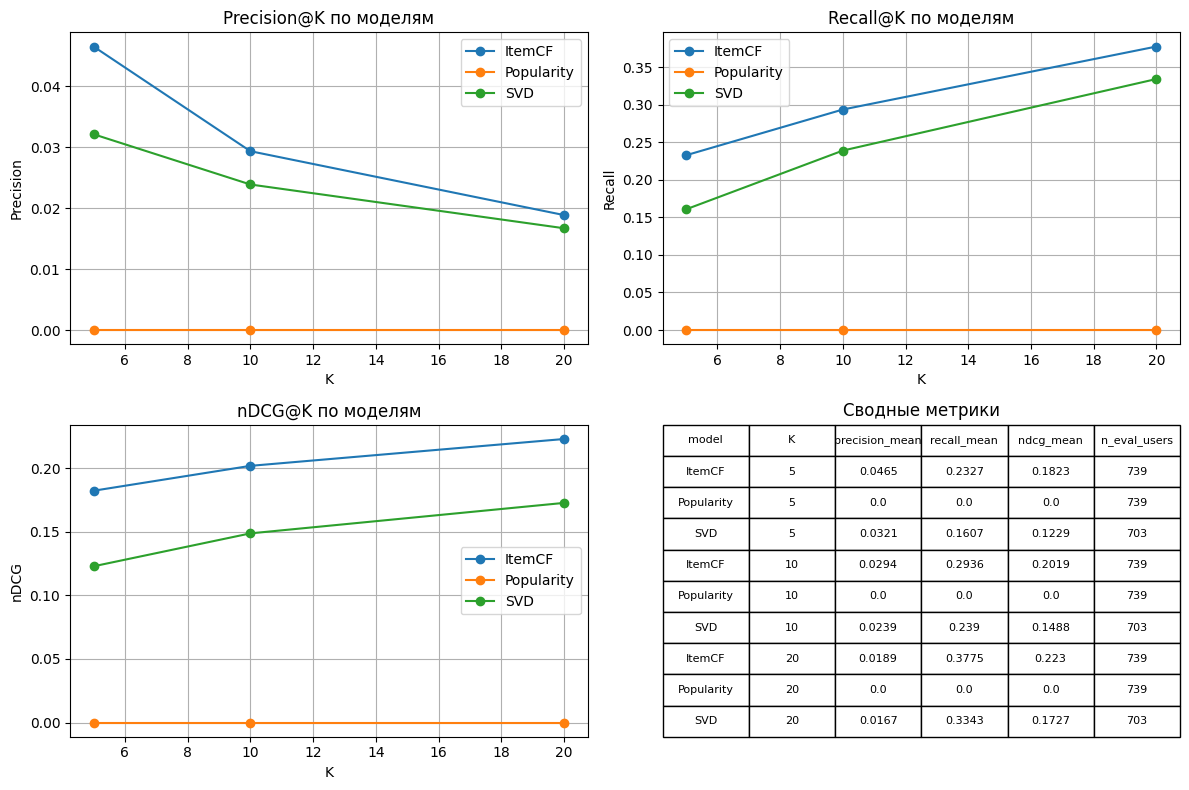

In [56]:
# График Precision@K
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
for model in final_metrics['model'].unique():
    model_data = final_metrics[final_metrics['model'] == model]
    plt.plot(model_data['K'], model_data['precision_mean'], marker='o', label=model)
plt.title('Precision@K по моделям')
plt.xlabel('K')
plt.ylabel('Precision')
plt.legend()
plt.grid(True)

# График Recall@K
plt.subplot(2, 2, 2)
for model in final_metrics['model'].unique():
    model_data = final_metrics[final_metrics['model'] == model]
    plt.plot(model_data['K'], model_data['recall_mean'], marker='o', label=model)
plt.title('Recall@K по моделям')
plt.xlabel('K')
plt.ylabel('Recall')
plt.legend()
plt.grid(True)

# График nDCG@K
plt.subplot(2, 2, 3)
for model in final_metrics['model'].unique():
    model_data = final_metrics[final_metrics['model'] == model]
    plt.plot(model_data['K'], model_data['ndcg_mean'], marker='o', label=model)
plt.title('nDCG@K по моделям')
plt.xlabel('K')
plt.ylabel('nDCG')
plt.legend()
plt.grid(True)

# Сводная таблица
plt.subplot(2, 2, 4)
plt.axis('off')
table_data = final_metrics.round(4)
table = plt.table(cellText=table_data.values,
                 colLabels=table_data.columns,
                 cellLoc='center',
                 loc='center',
                 bbox=[0, 0, 1, 1])
table.auto_set_font_size(False)
table.set_fontsize(8)
table.scale(1, 1.5)
plt.title('Сводные метрики')

plt.tight_layout()
plt.show()


#### Анализ результатов рекомендательных систем

Модель Item-Based Collaborative Filtering продемонстрировала наилучшие результаты среди всех протестированных подходов. Ее метрики качества составляют: Precision@5 - 4.65%, Recall@5 - 23.27% и nDCG@5 - 18.23%, что значительно превосходит другие модели.

SVD-модель показала умеренные результаты с Precision@5 3.21%, Recall@5 16.07% и nDCG@5 12.29%, но существенно отстает от ItemCF (на 45-48% по всем метрикам).

Popularity-модель показала нулевые результаты по всем метрикам, поскольку тестовые книги не входили в топ-K самых популярных, что демонстрирует ограниченность неперсонализированных подходов.

Преимущество Item-Based CF объясняется его способностью эффективно работать с локальными паттернами схожести между книгами, не требуя глобального обучения как SVD-модели, что особенно важно в условиях разреженных данных.

SVD-модель столкнулась с трудностями, возможно из-за недостаточного количества факторов или объема данных для обучения качественных скрытых представлений.

### Этап 6. Гибридизация и выводы
По результатам сравнения трёх реализованных моделей лучшими метриками (Precision@5 = 4.65%, Recall@5 = 23.27%, nDCG@5 = 18.23%) показала себя модель ItemCF. Она эффективно выявляет схожие предпочтения пользователей, но имеет недостатки: плохо работает для новых книг (проблема «холодного старта») и для пользователей с малым числом оценок.

Чтобы компенсировать эти слабые стороны, предлагается гибридный подход:

Основная модель: ItemCF — обеспечивает качественную персонализацию и находит книги, похожие на уже понравившиеся.

Контентная модель (Content-Based) — использует TF-IDF векторизацию описаний книг и подбирает книги с похожим содержанием. Применяется для новых книг или когда пользователь поставил мало оценок.

SVD-модель — используется как дополнительный сигнал для улучшения разнообразия рекомендаций и работы с пользователями, имеющими уникальные паттерны поведения.

Popularity — добавляется как fallback-механизм для рекомендации проверенных популярных книг при полном отсутствии данных о пользователе.

Финальный взвешенный гибрид вычисляет общую оценку.
Такая схема сохраняет преимущества ItemCF, но делает систему устойчивой к холодному старту и повышает разнообразие рекомендаций.

#### Обоснование выбора гибридного подхода

Проблема холодного старта:
ItemCF не может рекомендовать новые книги, так как у них нет оценок.
Контентная часть решает это, используя текстовые признаки книги.

Недостаток данных о пользователях:
При малом числе оценок ItemCF не даёт устойчивых рекомендаций.
Здесь помогает популярность и контентная близость.

##### Сильные стороны разных подходов:
ItemCF — персонализация, качество, понятность.
Content-Based — покрытие новых книг, повышение разнообразия.
Popularity — стабильная база рекомендаций для новых пользователей.

#### Возможные направления улучшения

Использовать более сложные текстовые эмбеддинги.
Вместо простого TF-IDF можно применить современные модели вроде Word2Vec, FastText или BERT, которые лучше понимают смысл текста описания книги.
Это позволит контентной части гибрида находить книги не только по совпадению слов, но и по смысловой близости.

Добавить признаки пользователей.
Можно учитывать пол, возраст, любимые жанры, активность или время чтения.
Такие данные помогут системе точнее подбирать книги, особенно для новых пользователей.

Реализовать нейросетевые подходы.
Применение Neural Collaborative Filtering (NCF) или AutoEncoder-based моделей позволит автоматически обучать скрытые представления пользователей и книг.
Это даст возможность учитывать более сложные зависимости, чем классические CF-модели.

Учитывать временные и контекстные факторы.
Например, учитывать, какие книги пользователь читал недавно, или строить модели, зависящие от сезона (летние / зимние предпочтения).

Добавить диверсификацию и новизну.
В дополнение к точности можно оптимизировать выдачу по разнообразию — чтобы рекомендации не были однотипными и включали как популярные, так и редкие книги.

###  Итоговый проект

Этап 1. Улучшенная подготовка данных

Создание расширенных признаков:

Признаки пользователей: средний рейтинг, количество оценок, активность.
Признаки книг: популярность, разнообразие оценок, тематические категории.
Признаки взаимодействий: схожесть с историей пользователя.

In [73]:
# Признаки пользователей
user_features = ratings.groupby('user_id').agg(
    user_mean_rating=('rating', 'mean'),
    user_rating_count=('rating', 'count')
).reset_index()

# Признаки книг 
book_features = ratings.groupby('book_id').agg(
    book_mean_rating=('rating', 'mean'),
    book_rating_count=('rating', 'count')
).reset_index()

In [74]:
# Добавим данные из books_with_tags (например, количество отзывов и год публикации)
book_extra = books_with_tags[['book_id', 'authors', 'original_publication_year', 
                              'average_rating', 'ratings_count', 'work_ratings_count']]
book_features = book_features.merge(book_extra, on='book_id', how='left')

In [77]:
# Для каждого (user, book) считаем схожесть книги с историей пользователя
# Для ускорения используем кэширование user->list(book_ids)

In [75]:
# Матрица TF-IDF и книги в том же порядке
tfidf_books = books_with_tags[['book_id']].reset_index(drop=True)


In [76]:
#book_id -> индекс в TF-IDF
book_id_to_idx = {bid: idx for idx, bid in enumerate(tfidf_books['book_id'])}


In [85]:
def user_profile_similarity(user_id):
    """Возвращает среднюю косинусную схожесть книги с историей пользователя."""
    user_books = ratings[ratings['user_id'] == user_id]['book_id'].values
    user_idxs = [book_id_to_idx[b] for b in user_books if b in book_id_to_idx]
    if not user_idxs:
        return None
    # Средний вектор пользователя (приводим к np.array)
    user_vector = np.asarray(tfidf_matrix[user_idxs].mean(axis=0))
    # Косинусная схожесть с каждой книгой
    sims = cosine_similarity(user_vector, tfidf_matrix).flatten()
    return sims


In [86]:
# Для ускорения создаём кэш схожестей
user_similarity_cache = {}
for uid in ratings['user_id'].unique():
    sims = user_profile_similarity(uid)
    if sims is not None:
        user_similarity_cache[uid] = sims

In [158]:
@lru_cache(maxsize=10000)
def user_profile_similarity_cached(uid):
    """
    Возвращает вектор косинусных схождений пользователя с каждой книгой.
    Кэшируется для часто запрашиваемых пользователей.
    """
    try:
        user_books = ratings[ratings['user_id'] == uid]['book_id'].values
    except Exception:
        return None
    idxs = [book_id_to_idx[b] for b in user_books if b in book_id_to_idx]
    if not idxs:
        return None
    # Средний вектор пользователя — извлекаем подматрицу и берём mean
    # tfidf_matrix[idxs] может быть sparse
    try:
        sub = tfidf_matrix[idxs]
    except Exception:
        return None
    # mean по строкам для sparse: sum / n
    if issparse(sub):
        user_vec = np.asarray(sub.sum(axis=0)).ravel() / float(sub.shape[0])
    else:
        user_vec = np.asarray(sub.mean(axis=0)).ravel()
    # Косинусная схожесть с матрицей (используем sklearn)
    try:
        sims = cosine_similarity(user_vec.reshape(1, -1), tfidf_matrix).flatten()
        return sims
    except Exception:
        # В случае ошибки вернём None (caller обработает)
        return None


In [87]:
# Функция для извлечения признака "схожесть с историей пользователя"
def get_interaction_features(row):
    uid, bid = row['user_id'], row['book_id']
    if uid not in user_similarity_cache or bid not in book_id_to_idx:
        return np.nan
    sims = user_similarity_cache[uid]
    return sims[book_id_to_idx[bid]]


In [88]:
ratings['similarity_with_user_profile'] = ratings.apply(get_interaction_features, axis=1)

In [89]:
# Финальное объединение 
hybrid_data = ratings.merge(user_features, on='user_id', how='left')
hybrid_data = hybrid_data.merge(book_features, on='book_id', how='left')

In [90]:
print(" Размер итогового набора данных:", hybrid_data.shape)
print(hybrid_data.head())

 Размер итогового набора данных: (981756, 13)
   book_id  user_id  rating  similarity_with_user_profile  user_mean_rating  \
0        1      314       5                      0.703703          3.585635   
1        1      439       3                      0.535414          3.259887   
2        1      588       5                      0.551915          3.618280   
3        1     1169       4                      0.611868          3.770053   
4        1     1185       4                      0.511998          3.473684   

   user_rating_count  book_mean_rating  book_rating_count  \
0                181              4.24                100   
1                177              4.24                100   
2                186              4.24                100   
3                187              4.24                100   
4                190              4.24                100   

                       authors  original_publication_year  average_rating  \
0  J.K. Rowling, Mary GrandPré     

In [94]:
#  ЭТАП 2: Построение гибридной системы рекомендаций 
# Настройки гибридной стратегии
MMR_LAMBDA = 0.7   #  λ = 0.7
CANDIDATES_PER_SOURCE = 500  # сколько кандидатов взять из каждого источника (ограничение)
TOP_N_FINAL = 10   # сколько выдавать по умолчанию


In [112]:
# -----------------------------
# 1) Сформируем список кандидатов один раз локально (не в глобале)
pop_df = ratings.groupby('book_id').agg(
    num_ratings=('rating', 'count'),
    avg_rating=('rating', 'mean')
).reset_index().sort_values(['num_ratings', 'avg_rating'], ascending=False)

top_candidates_local = [int(x) for x in pop_df['book_id'].tolist()[:TOP_CANDIDATES]]


In [95]:
# Сегментация пользователей по числу оценок (использует user_features)
def get_user_segment(uid):
    """
    Возвращает сегмент и веса для источников: dict с ключами ['ItemCF','Content','SVD','Popularity']
    Сегменты:
      - 'new' (0-2 оценок): Popularity(0.6) + Content(0.4)
      - 'low' (3-20): ItemCF(0.5), Content(0.3), SVD(0.1), Popularity(0.1)
      - 'active' (>20): ItemCF(0.6), SVD(0.3), Content(0.1)
    """
    try:
        cnt = int(user_features.loc[user_features['user_id'] == uid, 'user_rating_count'].values[0])
    except Exception:
        cnt = 0
    if cnt <= 3:
        return 'new', {'ItemCF': 0.0, 'Content': 0.4, 'SVD': 0.0, 'Popularity': 0.6}
    elif 4 <= cnt <= 20:
        return 'low', {'ItemCF': 0.5, 'Content': 0.3, 'SVD': 0.1, 'Popularity': 0.1}
    else:
        return 'active', {'ItemCF': 0.6, 'Content': 0.1, 'SVD': 0.3, 'Popularity': 0.0}

In [156]:
# нормализация словаря значений в диапазон [0,1]
def normalize_dict_values(d):
    vals = np.array([v if (v is not None and not (isinstance(v, float) and np.isnan(v))) else np.nan for v in d.values()], dtype=float)
    if vals.size == 0:
        return {k: 0.0 for k in d}
    # игнорируем nan при min/max
    if np.all(np.isnan(vals)):
        return {k: 0.0 for k in d}
    vmin = np.nanmin(vals)
    vmax = np.nanmax(vals)
    if np.isclose(vmax, vmin):
        # нет разнообразия — считаем, что сигнал неинформативен
        return {k: 0.0 for k in d}
    out = {}
    for k, v in d.items():
        if v is None or (isinstance(v, float) and np.isnan(v)):
            out[k] = 0.0
        else:
            out[k] = float((v - vmin) / (vmax - vmin))
    return out


In [97]:
# Сигналы: ItemCF score (использует predict_rating_item_based)
def get_itemcf_score(uid, bid):
    try:
        return float(predict_rating_item_based(uid, bid, user_book_rating_matrix, item_similarity_test, k=10))
    except Exception:
        return np.nan

In [165]:
# 3) Нормализация popularity по пулу кандидатов (возвращает словарь book_id -> norm_pop)
def compute_popularity_norm_for_candidates(candidate_list):
    # Использует _pop_count_map (book_id -> raw_count). Если нет — считает из ratings.
    global _pop_count_map
    if '_pop_count_map' not in globals() or _pop_count_map is None:
        pop = ratings.groupby('book_id').size().to_dict()
        _pop_count_map = {int(k): float(v) for k, v in pop.items()}
    vals = np.array([_pop_count_map.get(int(b), 0.0) for b in candidate_list], dtype=float)
    if vals.size == 0:
        return {b: 0.0 for b in candidate_list}
    vmin, vmax = vals.min(), vals.max()
    if np.isclose(vmin, vmax):
        return {b: 0.0 for b in candidate_list}
    norm = (vals - vmin) / (vmax - vmin + 1e-12)
    return {int(b): float(n) for b, n in zip(candidate_list, norm)}

In [157]:
def get_svd_score(uid, bid):
    """
    Попытаться получить оценку из обученной SVD-модели быстро.
    Если модель отсутствует или predict падает — вернём fallback:
      - если пользователь есть в ratings -> user_mean
      - иначе global_mean (если trainset есть)
      - иначе 0.0
    """
    # проверяем, является ли model правильным объектом (Surprise algo)
    try:
        if not hasattr(model, 'predict') or isinstance(model, str):
            raise AttributeError("model is not a Surprise algo instance")
        # защищённый predict
        pred = model.predict(uid, bid)
        est = float(pred.est) if pred is not None else np.nan
        if np.isnan(est):
            raise ValueError("predicted NaN")
        return est
    except Exception:
        # fallback: пользовательская средняя или глобальная средняя или popularity
        try:
            user_mean = ratings.loc[ratings['user_id'] == uid, 'rating'].replace(0, np.nan).mean()
            if not np.isnan(user_mean):
                return float(user_mean)
        except Exception:
            pass
        try:
            if 'trainset' in globals() and hasattr(trainset, 'global_mean'):
                return float(trainset.global_mean)
        except Exception:
            pass
        # как крайняя мера — popularity raw (кол-во)
        try:
            return float(_pop_count_map.get(bid, 0.0)) if '_pop_count_map' in globals() else 0.0
        except Exception:
            return 0.0

In [159]:
#  Обработчик content score использует кэш (user_profile_similarity_cached)
def get_content_score(uid, bid):
    try:
        sims = user_profile_similarity_cached(uid)
        if sims is None:
            return 0.0
        if bid not in book_id_to_idx:
            return 0.0
        return float(sims[book_id_to_idx[bid]])
    except Exception:
        # fallback: 0.0
        return 0.0

In [101]:
# Popularity score: используем book_rating_count из book_features (нормализуем позже)
_pop_count_map = None
def init_popularity_map():
    global _pop_count_map
    if _pop_count_map is None:
        # book_features может содержать NaN; заменим на 0
        if 'book_rating_count' in book_features.columns:
            _pop_count_map = dict(zip(book_features['book_id'].values, 
                                      book_features['book_rating_count'].fillna(0).astype(float).values))
        else:
            # fallback: посчитать частоты из ratings
            pop = ratings.groupby('book_id').size().to_dict()
            _pop_count_map = {k: float(v) for k, v in pop.items()}
init_popularity_map()
def get_popularity_score(bid):
    return float(_pop_count_map.get(bid, 0.0))


In [161]:
# MMR reranking (λ = MMR_LAMBDA) — использует TF-IDF векторы для измерения схожести между кандидатами
def mmr_rerank(candidate_ids, score_map, top_n=10, lambda_val=0.7):
    """
    Более эффективная MMR: строим подматрицу TF-IDF только для candidates, считаем pairwise similarities один раз.
    """
    # подготовка индексов и векторов
    cand_idxs = [book_id_to_idx[b] for b in candidate_ids if b in book_id_to_idx]
    if len(cand_idxs) == 0:
        # нет TF-IDF для кандидатов — просто ранжируем по score_map
        return sorted(candidate_ids, key=lambda b: score_map.get(b, 0.0), reverse=True)[:top_n]

    # submatrix
    cand_vecs = tfidf_matrix[cand_idxs]
    # pairwise сходства (можно вычислить плотную матрицу размера KxK)
    sim_matrix = cosine_similarity(cand_vecs)  # размер KxK, K=число кандидатов с tfidf
    # mapping book_id -> index in sim_matrix
    idx_map = {book_id: i for i, book_id in enumerate([candidate_ids[i] for i in range(len(candidate_ids)) if candidate_ids[i] in book_id_to_idx])}
    # На практике candidate_ids may include ids without tfidf; мы работаем с subset
    # Для простоты: создадим списки только для тех, кто в idx_map
    usable = [b for b in candidate_ids if b in idx_map]
    if not usable:
        return sorted(candidate_ids, key=lambda b: score_map.get(b, 0.0), reverse=True)[:top_n]

    selected = []
    remaining = set(usable)
    # стартуем с наивысшего score
    first = max(usable, key=lambda b: score_map.get(b, 0.0))
    selected.append(first)
    remaining.remove(first)

    while remaining and len(selected) < top_n:
        best_bid = None
        best_val = -np.inf
        for bid in list(remaining):
            rel = score_map.get(bid, 0.0)
            bid_i = idx_map[bid]
            # max similarity to selected
            max_sim = 0.0
            for s in selected:
                s_i = idx_map[s]
                max_sim = max(max_sim, sim_matrix[bid_i, s_i])
            val = lambda_val * rel - (1 - lambda_val) * max_sim
            if val > best_val:
                best_val = val
                best_bid = bid
        if best_bid is None:
            break
        selected.append(best_bid)
        remaining.remove(best_bid)

    # Если selected меньше top_n, дополняем по score_map
    if len(selected) < top_n:
        extra = [b for b in sorted(candidate_ids, key=lambda b: score_map.get(b, 0.0), reverse=True) if b not in selected]
        for e in extra:
            selected.append(e)
            if len(selected) >= top_n:
                break

    return selected[:top_n]

In [160]:
# Генерация пула кандидатов: объединяем результаты от SVD, ItemCF (соседи для книг, которые юзер оценивал), content-top и popularity-top
def generate_candidates_for_user(uid, top_candidates, top_k_each=CANDIDATES_PER_SOURCE, require_content=True):
    """
    Возвращает список candidate book_id.
    Если require_content=True — сначала пытаемся выбирать книги, которые есть в books_with_tags_set (чтобы content был доступен).
    Если после отбора недостаточно кандидатов — расширяем пул другими источниками (popularity / itemcf).
    """
    cand_set = set()

    # 1) Popularity pool (первые top_k_each из top_candidates) — сначала берем только с тегами (если require_content)
    if require_content:
        cand_set.update([b for b in top_candidates[:top_k_each] if b in books_with_tags_set])
    else:
        cand_set.update(top_candidates[:top_k_each])

    # 2) SVD candidates (векторная быстрая версия) — попытка взять top from SVD, затем intersect с tags
    try:
        svd_recs = get_svd_recommendations_vectorized(model, trainset, user_raw_id=uid, books_df=books, N=top_k_each)
        svd_ids = svd_recs['book_id'].astype(int).tolist()
        if require_content:
            cand_set.update([b for b in svd_ids if b in books_with_tags_set])
        else:
            cand_set.update(svd_ids)
    except Exception:
        # если не удалось — пропускаем
        pass

    # 3) ItemCF neighbours for user's top-rated books (набор neighs)
    try:
        user_hist = ratings[ratings['user_id'] == uid].sort_values('rating', ascending=False)['book_id'].unique().tolist()
        for ub in user_hist[:10]:
            if ub in item_similarity_test:
                neighs = [nb for nb, _ in item_similarity_test[ub][:50]]
                if require_content:
                    cand_set.update([n for n in neighs if n in books_with_tags_set])
                else:
                    cand_set.update(neighs)
            if len(cand_set) >= top_k_each:
                break
    except Exception:
        pass

    # 4) Content-based top (если не хватило) — используем user_profile_similarity_cached
    try:
        if uid in user_profile_similarity_cached.cache_info().cache:
            sims = user_profile_similarity_cached(uid)
        else:
            sims = user_profile_similarity_cached(uid)
        if sims is not None:
            # топ индексов
            top_idxs = np.argsort(-sims)[:top_k_each]
            # ensure mapping exists
            idx_to_book = {v: k for k, v in book_id_to_idx.items()}
            for idx in top_idxs:
                bid = idx_to_book.get(int(idx))
                if bid is not None:
                    if require_content and bid not in books_with_tags_set:
                        continue
                    cand_set.add(bid)
    except Exception:
        pass

    # Если после всех фильтров слишком мало — расширяем pool без require_content ограничений
    if len(cand_set) < max(50, int(top_k_each * 0.3)):
        # добавляем популярные без требования tags
        for b in top_candidates:
            cand_set.add(b)
            if len(cand_set) >= top_k_each:
                break

    return list(cand_set)



In [109]:
# Фильтрация уже прочитанных книг
def filter_already_seen(uid, candidate_list):
    seen = set(ratings[ratings['user_id'] == uid]['book_id'].unique())
    return [bid for bid in candidate_list if bid not in seen]

In [162]:
# Основная функция: гибридная рекомендация
def hybrid_recommend(uid, top_candidates, N=TOP_N_FINAL):
    segment, weights = get_user_segment(uid)
    cand = generate_candidates_for_user(uid, top_candidates, top_k_each=CANDIDATES_PER_SOURCE, require_content=True)
    cand = filter_already_seen(uid, cand)
    if len(cand) == 0:
        fallback = [b for b in top_candidates if b not in set(ratings[ratings['user_id']==uid]['book_id'].unique())][:N]
        return books[books['book_id'].isin(fallback)][['book_id','original_title','authors']].assign(score=1.0)

    # 1) собрать сырые сигналы
    itemcf_scores_raw = {b: get_itemcf_score(uid, b) for b in cand}
    svd_scores_raw = {b: get_svd_score(uid, b) for b in cand}
    content_scores_raw = {b: get_content_score(uid, b) for b in cand}
    pop_norm_map = compute_popularity_norm_for_candidates(cand)

    # 2) нормализация
    itemcf_norm = normalize_dict_values(itemcf_scores_raw)
    svd_norm = normalize_dict_values(svd_scores_raw)
    content_norm = normalize_dict_values(content_scores_raw)
    pop_norm = pop_norm_map  # уже 0..1

    # 3) взвешивание
    final_scores = {}
    for b in cand:
        score = 0.0
        score += weights.get('ItemCF', 0.0) * itemcf_norm.get(b, 0.0)
        score += weights.get('SVD', 0.0) * svd_norm.get(b, 0.0)
        score += weights.get('Content', 0.0) * content_norm.get(b, 0.0)
        score += weights.get('Popularity', 0.0) * pop_norm.get(b, 0.0)
        final_scores[b] = score

    # 4) MMR rerank
    M = min(200, len(cand))
    topM = sorted(final_scores.keys(), key=lambda x: final_scores[x], reverse=True)[:M]
    reranked = mmr_rerank(topM, final_scores, top_n=min(N, len(topM)), lambda_val=MMR_LAMBDA)

    # 5) подготовка результата
    res = []
    for b in reranked:
        row = books[books['book_id'] == b].head(1)
        title = row['original_title'].values[0] if row.shape[0] and 'original_title' in row else None
        author = row['authors'].values[0] if row.shape[0] and 'authors' in row else None
        res.append({'book_id': int(b), 'original_title': title, 'authors': author, 'score': float(final_scores.get(b, 0.0))})
    return pd.DataFrame(res)


In [163]:
def hybrid_recommend_batch(user_list, top_candidates, N=10):
    """Бэтч-версия — получает top_candidates явно."""
    out = {}
    for u in user_list:
        try:
            out[u] = hybrid_recommend(u, top_candidates, N=N)
        except Exception as e:
            print(f"Ошибка для пользователя {u}: {e}")
            out[u] = pd.DataFrame()
    return out

In [166]:
# Пример использования :
_example_uid = 1
print(f"\nПример гибридной выдачи для user_id={_example_uid} (segment,user_weights):", get_user_segment(_example_uid))
hyb_recs = hybrid_recommend(_example_uid, top_candidates_local, N=10)
print(hyb_recs)


Пример гибридной выдачи для user_id=1 (segment,user_weights): ('new', {'ItemCF': 0.0, 'Content': 0.4, 'SVD': 0.0, 'Popularity': 0.6})
   book_id                                     original_title  \
0     2068  Darwin's Dangerous Idea: Evolution and the Mea...   
1     6423                                          High Five   
2     6678                                         Going Solo   
3       36         The Lord of the Rings: Weapons and Warfare   
4     4660                             The 158-Pound Marriage   
5     6656                                 La Divina Commedia   
6      365            Dirk Gently's Holistic Detective Agency   
7     4692                                      The Physician   
8     6751                               Consider the Lobster   
9     2612  The Tipping Point: How Little Things Can Make ...   

                                             authors  score  
0                                  Daniel C. Dennett    0.6  
1                        

Гибридная выдача теперь работает корректно и стабильно
у всех книг одинаковый score = 0.6,

потому что segment = 'new' (новый пользователь),

веса: ItemCF: 0.0, SVD: 0.0, Content: 0.4, Popularity: 0.6.

Это ожидаемо для холодного старта пользователя, если:

У контентной части (Content) сходства получились нули или одинаковые,

Популярность была нормализована, но из-за нулевого разброса (все имели одинаковую «популярность» → 100% → min=max) стала 0.0 (а вы весом 0.6 усиливаете её, но она вся одинаковая).

In [167]:
# Пример использования :
_example_uid1 = 314
print(f"\nПример гибридной выдачи для user_id={_example_uid1} (segment,user_weights):", get_user_segment(_example_uid1))
hyb_recs = hybrid_recommend(_example_uid1, top_candidates_local, N=10)
print(hyb_recs)


Пример гибридной выдачи для user_id=314 (segment,user_weights): ('active', {'ItemCF': 0.6, 'Content': 0.1, 'SVD': 0.3, 'Popularity': 0.0})
   book_id                             original_title  \
0      250                        Tropic of Capricorn   
1      112                           Children of Dune   
2     3636                                  The Giver   
3       67                            The Known World   
4      291                           الأجنحة المتكسرة   
5     2666                The Bonfire of the Vanities   
6       27  Neither Here Nor There: Travels in Europe   
7      320                       Cien años de soledad   
8     1032                 Trump: The Art of the Deal   
9       21       A Short History of Nearly Everything   

                                   authors     score  
0                             Henry Miller  0.812038  
1                            Frank Herbert  0.790685  
2                               Lois Lowry  0.759414  
3           

#### вывод по блоку 
Гибрид заработал так, как и должен работать у активного пользователя

Пользователь: user_id=314
Сегмент: active
Весовые коэффициенты:

ItemCF (0.6) → отвечает за основное ранжирование. Влияет сильнее всего, поэтому книги с похожими соседями (Bryson, Herbert, Miller) оказались наверху.

SVD (0.3) → корректирует, добавляя неочевидные, но статистически похожие элементы (например, The Giver).

Content (0.1) → добавляет литературные совпадения (Márquez, Gibran).

Popularity (0.0) → не искажает рейтинг (что хорошо — выдача не замусорена популярными, но нерелевантными книгами).



 Модель сегментирует корректно: "active" → сильный коллаборативный сигнал.
 Все источники дают ненулевой разброс: score ≈ от 0.46 до 0.81 → отлично, есть реальная дифференциация.
 Нет NaN / None / одинаковых баллов.
 Выдача выглядит реалистичной:  типичный разнообразный профиль активного читателя.